In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt


# Preprocessing

In [40]:
def combine_common_columns(delimiter="\t"):
    dfs = []
    common_cols = None
    
    for file in os.listdir():
        if file.endswith(".txt") or file.endswith(".tsv"):
            try:
                df = pd.read_csv(file, delimiter=delimiter, low_memory=False)
                df["source_file"] = file  # Optional: track source

                # Initialize or update common column set
                cols = set(df.columns)
                if common_cols is None:
                    common_cols = cols
                else:
                    common_cols &= cols  # intersection

                dfs.append(df)
            except Exception as e:
                print(f"Failed to read {file}: {e}")

    if not dfs or not common_cols:
        print("No compatible files found.")
        return pd.DataFrame()

    # Trim all DataFrames to common columns (including source_file if desired)
    common_cols = list(common_cols)
    final_dfs = [df[common_cols] for df in dfs]

    return pd.concat(final_dfs, ignore_index=True)

In [41]:
def combine_common_columns_with_age(delimiter="\t"):
    """
    Combines .txt and .tsv files in the current directory using only common columns,
    and standardizes the age column (e.g., 'AGE2', 'AGE3') to 'AGE'.

    Parameters:
    - delimiter (str): Delimiter used in the text/tsv files.

    Returns:
    - pd.DataFrame: Combined DataFrame with standardized age column and common columns.
    """
    dfs = []
    common_cols = None
    age_column_candidates = ['AGE2', 'AGE3']

    for file in os.listdir():
        if file.endswith(".txt") or file.endswith(".tsv"):
            try:
                df = pd.read_csv(file, delimiter=delimiter, low_memory=False)
                df["source_file"] = file  # optional: track origin

                # Rename age column if it exists
                for age_col in age_column_candidates:
                    if age_col in df.columns:
                        df = df.rename(columns={age_col: "AGE"})
                        break  # Stop once one match is found

                # Update common columns (excluding age — handled separately)
                cols = set(df.columns) - {"source_file"}  # don't require this to be common
                if common_cols is None:
                    common_cols = cols
                else:
                    common_cols &= cols

                dfs.append(df)
            except Exception as e:
                print(f"Failed to read {file}: {e}")

    if not dfs or not common_cols:
        print("No compatible files found.")
        return pd.DataFrame()

    # Ensure AGE and source_file are retained if present
    final_cols = list(common_cols | {"AGE", "source_file"})

    final_dfs = [df[[col for col in final_cols if col in df.columns]] for df in dfs]
    return pd.concat(final_dfs, ignore_index=True)

In [42]:
big = combine_common_columns_with_age()

In [43]:
big["source_file"].value_counts()

source_file
NSDUH_2022_Tab.txt    59069
NSDUH_2021_Tab.txt    58034
NSDUH_2016_Tab.tsv    56897
NSDUH_2023_Tab.txt    56705
NSDUH_2018_Tab.tsv    56313
NSDUH_2017_Tab.tsv    56276
NSDUH_2019_Tab.txt    56136
NSDUH_2020_Tab.txt    32893
Name: count, dtype: int64

In [44]:
# Mask for files with '2022' or '2023' in source_file
recent_mask = big["source_file"].str.contains("2021|2022|2023")

# Subset 1: source_file contains 2022 or 2023 AND age between 4 and 7
subset_recent = big[recent_mask & big["AGE"].between(4, 7)]

# Subset 2: all other files AND age between 7 and 13
subset_older = big[~recent_mask & big["AGE"].between(7, 13)]

# Combine the two subsets
big_filtered = pd.concat([subset_recent, subset_older], ignore_index=True)

In [45]:
big_filtered['source_file'].value_counts()

source_file
NSDUH_2022_Tab.txt    18310
NSDUH_2019_Tab.txt    18133
NSDUH_2021_Tab.txt    18044
NSDUH_2017_Tab.tsv    17829
NSDUH_2016_Tab.tsv    17608
NSDUH_2018_Tab.tsv    17505
NSDUH_2023_Tab.txt    17471
NSDUH_2020_Tab.txt    10393
Name: count, dtype: int64

In [46]:
big_filtered["AGE"].value_counts()

AGE
7     20121
13    18159
12    16648
5     16148
11    15936
4     14614
6     11111
10     7650
8      7466
9      7440
Name: count, dtype: int64

In [47]:
big_filtered

,ASOCMDE,IICRKRC,ADDSCEV,SEDNM30FQ,INHDYPMO,AD_MDEA8,IISEDNMINIT,IRSTMNMAGE,CIGCRAVE,IIHERFM,...,ARELMDE,IIMETHAM30N,HLTINMNT,NOBOOKY2,ADWRNOGD,CIGDLLST,NMERTMT2,RSKBNGDLY,CIRROSAGE,YOSTOLE2
0,NaN,1,2,91,91,98,1,999,93,9,...,NaN,9,1,999,99,20,0,4,999,NaN
1,NaN,1,98,98,91,98,4,999,91,9,...,NaN,9,2,985,98,991,985,2,998,NaN
2,0.0,1,99,91,91,1,1,999,93,9,...,0.0,9,1,999,1,999,0,4,999,NaN
3,NaN,1,2,93,93,98,1,993,1,9,...,NaN,9,1,999,99,999,0,3,999,NaN
4,NaN,1,2,91,91,98,1,999,91,9,...,NaN,9,99,999,99,991,0,4,999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135288,0.0,1,99,91,91,1,1,999,1,9,...,0.0,9,2,999,2,999,1,4,999,NaN
135289,NaN,1,99,91,91,98,1,999,93,9,...,NaN,9,99,999,99,999,0,4,999,NaN
135290,NaN,1,99,91,91,98,1,999,93,9,...,NaN,9,1,999,99,999,0,3,999,NaN
135291,NaN,1,1,91,93,98,1,999,93,9,...,NaN,9,99,999,99,999,0,4,999,NaN


In [48]:
filtered_columns = [col for col in big_filtered.columns if col.startswith(('ALC', 'ALD', 'UAD', 'AGE', 'FILEDATE', 'IRSEX', 'source_file', 'AL30'))]

# Create a new DataFrame with just those columns
df_filtered = big_filtered[filtered_columns]
df_filtered["year"] = df_filtered["source_file"].str.extract(r"(20\d{2})")
df_filtered = df_filtered[(df_filtered["ALCEVER"] == 1) | (df_filtered["ALCEVER"] == 2)]

/var/folders/l8/4ddk30qs673179tzbywg5n080000gn/T/ipykernel_10244/1405227620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["year"] = df_filtered["source_file"].str.extract(r"(20\d{2})")


In [49]:
year_counts = (
    df_filtered.groupby("year")["ALCEVER"]
    .value_counts(normalize=True)  # gives proportions (0 to 1)
    .rename("percent")
    .reset_index()
)
alc_pct_pivot = year_counts.pivot(index="ALCEVER",columns="year", values="percent")

In [50]:
alc_pct_pivot

year,2016,2017,2018,2019,2020,2021,2022,2023
ALCEVER,,,,,,,,
1,0.83517,0.835054,0.822702,0.819807,0.792128,0.770203,0.763057,0.764527
2,0.16483,0.164946,0.177298,0.180193,0.207872,0.229797,0.236943,0.235473


<BarContainer object of 8 artists>

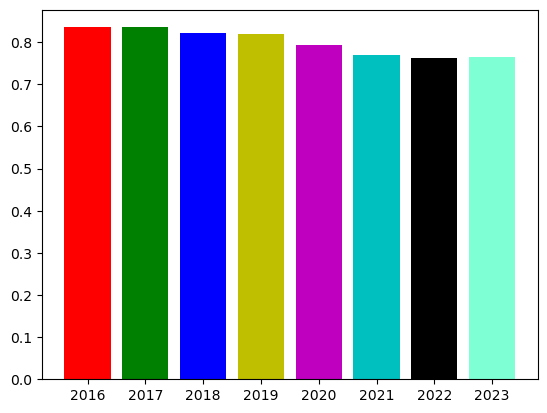

In [51]:
plt.bar(alc_pct_pivot.columns, alc_pct_pivot.loc[1], color = ['r','g','b','y','m','c', 'k', 'aquamarine'])

In [52]:
alc_pct_pivot

year,2016,2017,2018,2019,2020,2021,2022,2023
ALCEVER,,,,,,,,
1,0.83517,0.835054,0.822702,0.819807,0.792128,0.770203,0.763057,0.764527
2,0.16483,0.164946,0.177298,0.180193,0.207872,0.229797,0.236943,0.235473


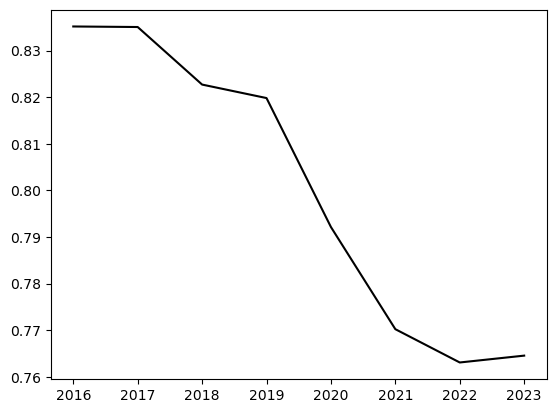

In [53]:
plt.plot(alc_pct_pivot.columns, alc_pct_pivot.loc[1], color = 'k')

In [54]:
past_month = (df_filtered[df_filtered['ALCDAYS'] < 31].groupby("year")["ALCDAYS"]
              .mean()
             )
#days_pivot = year_counts.pivot(index="ALCEVER",columns="year", values="counts")
past_month

year
2016    6.929723
2017    6.941568
2018    6.809300
2019    6.689551
2020    6.964664
2021    6.804631
2022    6.397290
2023    6.277804
Name: ALCDAYS, dtype: float64

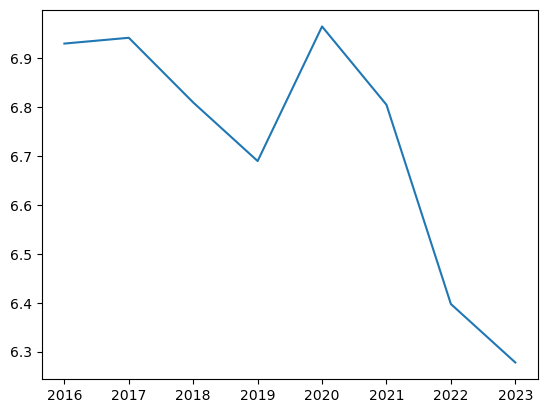

In [55]:
plt.plot(past_month)

| **Variable**   | **Description**                              | **Values & Labels**                                                                                                                                                                                           |
| -------------- | -------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **ALCEVER**    | Ever had a drink of alcohol (even once)      | 1 = Yes, 2 = No                                                                                                                                                                                               |
| **ALCYFU**     | Year of first alcohol use (recode)           | 2021–2023 = Valid year<br>9985 = Bad data<br>9989/9999 = Legitimate skip<br>9991 = Never used<br>9994 = Don’t know<br>9997 = Refused<br>9998 = Blank                                                          |
| **ALCMFU**     | Month of first alcohol use (recode)          | 1–12 = Jan–Dec<br>85 = Bad data<br>89/99 = Legit skip<br>91 = Never used<br>94 = Don’t know<br>97 = Refused<br>98 = Blank                                                                                     |
| **ALCREC**     | Time since last drank alcohol                | 1 = Past 30 days<br>2 = 30 days–12 mo<br>3 = Over 12 mo<br>8/9/11 = Logic-assigned use<br>85 = Bad data<br>91 = Never used<br>97 = Refused<br>98 = Blank                                                      |
| **ALCYRTOT**   | Total # days used alcohol in past 12 mo      | 1–365 = Valid<br>985 = Bad data<br>991 = Never used<br>993 = Did not use<br>994 = Don’t know<br>997 = Refused<br>998 = Blank                                                                                  |
| **ALTOTFG**    | Trimmed indicator for ALCYRTOT               | 1 = Trimmed to 365<br>2 = Trimmed relative to 30-day freq<br>98 = Blank                                                                                                                                       |
| **ALFQFLG**    | Trimmed if used <12 months                   | 1 = Trimmed to be consistent<br>98 = Blank                                                                                                                                                                    |
| **ALBSTWAY**   | Preferred way to report # days drank         | 1 = Per week<br>2 = Per month<br>3 = Per year<br>11–13 = Logic-assigned<br>85 = Bad data<br>91 = Never used<br>93 = No past 12-mo use<br>94 = Don’t know<br>97 = Refused<br>98 = Blank                        |
| **ALDAYPYR**   | # days drank in past 12 months               | 1–365 = Valid<br>985 = Bad data<br>989 = Legit skip<br>991 = Never used<br>993 = Didn’t use<br>994 = Don’t know<br>997 = Refused<br>998 = Blank<br>999 = Legit skip                                           |
| **ALDAYPMO**   | Avg days/month drank past 12 months          | 1–31 = Valid<br>85 = Bad data<br>89 = Legit skip<br>91 = Never used<br>93 = Didn’t use<br>94 = Don’t know<br>97 = Refused<br>98 = Blank<br>99 = Legit skip                                                    |
| **ALDAYPWK**   | Avg days/week drank past 12 months           | 1–7 = Valid<br>85 = Bad data<br>91 = Never used<br>93 = Didn’t use<br>94 = Don’t know<br>97 = Refused<br>98 = Blank<br>99 = Legit skip                                                                        |
| **ALCDAYS**    | Days had ≥1 drink in past 30 days            | 1–30 = Valid<br>85 = Bad data<br>91 = Never used<br>93 = Didn’t use<br>94 = Don’t know<br>97 = Refused<br>98 = Blank                                                                                          |
| **AL30EST**    | Estimate of # drinking days past 30 days     | 1 = 1–2 days<br>2 = 3–5 days<br>3 = 6–9 days<br>4 = 10–19 days<br>5 = 20–29 days<br>6 = All 30 days<br>91 = Never used<br>93 = Didn’t use<br>94 = Don’t know<br>97 = Refused<br>98 = Blank<br>99 = Legit skip |
| **ALCUS30D**   | Usual # drinks per day past 30 days          | 1–60 = Valid<br>975 = At least 4–5<br>985 = Bad data<br>991 = Never used<br>993 = Didn’t use<br>994 = Don’t know<br>997 = Refused<br>998 = Blank                                                              |
| **UADPEOP**    | Social context of most recent alcohol use    | 1 = Alone<br>2 = With one<br>3 = With more than one<br>4 = No recent use / 21+<br>. = Unknown                                                                                                                 |
| **UADSCHL**    | Alcohol use at school                        | 1 = Yes<br>2 = No<br>. = Unknown / 21+                                                                                                                                                                        |
| **UADROTH**    | Drank at "some other place"                  | 1 = Yes<br>2 = No<br>. = Unknown                                                                                                                                                                              |
| **UADOTSP2**   | Specific other place (e.g., party, outdoors) | 1 = Party/event<br>2 = Outside<br>3 = Hotel<br>4 = Camping<br>7 = Other<br>. = Unknown                                                                                                                        |
| **UADPAID**    | Underage paid for alcohol                    | 1 = Yes<br>2 = No<br>3 = No PM use / 21+<br>. = Unknown                                                                                                                                                       |
| **UADMONY**    | How underage got alcohol                     | 1 = Bought self<br>2 = Gave money to someone<br>3 = No PM use / 21+<br>. = Unknown                                                                                                                            |
| **UADBWHO**    | Where alcohol was bought                     | 1 = Store/bar/etc.<br>2 = Another person<br>3 = No PM use / 21+<br>. = Unknown                                                                                                                                |
| **UADPLACE**   | Purchase location                            | 1 = Liquor/grocery store<br>2 = Restaurant/bar<br>3 = Event<br>4 = No PM use / 21+<br>. = Unknown                                                                                                             |
| **UADBUND**    | Age of person who bought alcohol             | 1 = Under 21<br>2 = 21+<br>3 = No PM use / 21+<br>. = Unknown                                                                                                                                                 |
| **UADCAG**     | Who purchased alcohol for underage           | 1 = Parent<br>2 = Family 21+<br>3 = Non-relative 21+<br>4 = Under 21<br>5 = No PM use / 21+<br>. = Unknown                                                                                                    |
| **UADFWHO**    | Who gave alcohol to underage                 | 1 = Parent<br>2 = Family 21+<br>3 = Non-relative 21+<br>4 = Under 21<br>5 = Took from home<br>6 = Took from others’ home<br>7 = Some other way<br>8 = No PM use / 21+<br>. = Unknown                          |
| **UADFRD**     | Got alcohol from a friend                    | 1 = Yes<br>2 = No<br>3 = No PM use / 21+<br>. = Unknown                                                                                                                                                       |
| **CADRKMARJ2** | Used marijuana with alcohol                  | 1 = Yes<br>0 = No<br>. = Unknown                                                                                                                                                                              |
| **CADRKCOCN2** | Used cocaine with alcohol                    | 1 = Yes<br>0 = No<br>. = Unknown                                                                                                                                                                              |
| **CADRKHERN2** | Used heroin with alcohol                     | 1 = Yes<br>0 = No<br>. = Unknown                                                                                                                                                                              |
| **CADRKHALL2** | Used hallucinogens with alcohol              | 1 = Yes<br>0 = No<br>. = Unknown                                                                                                                                                                              |
| **CADRKINHL2** | Used inhalants with alcohol                  | 1 = Yes<br>0 = No<br>. = Unknown                                                                                                                                                                              |
| **CADRKMETH2** | Used methamphetamine with alcohol            | 1 = Yes<br>0 = No<br>. = Unknown                                                                                                                                                                              |


In [56]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135255 entries, 0 to 135292
Data columns (total 46 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UADCAG       134232 non-null  float64
 1   ALCAGLST     135255 non-null  int64  
 2   UADMONY      134327 non-null  float64
 3   ALCDAYS      135255 non-null  int64  
 4   UADOTHM      12429 non-null   float64
 5   UADPEOP      134380 non-null  float64
 6   UADBWHO      134319 non-null  float64
 7   UADBAR       12429 non-null   float64
 8   ALDAYPMO     135255 non-null  int64  
 9   ALCMFU       135255 non-null  int64  
 10  ALCMON       135255 non-null  int64  
 11  source_file  135255 non-null  object 
 12  UADBUND      134319 non-null  float64
 13  ALCUS30D     135255 non-null  int64  
 14  IRSEX        135255 non-null  int64  
 15  ALCMDAYS     135255 non-null  int64  
 16  UADPUBL      12429 non-null   float64
 17  ALCYRBFR     135255 non-null  int64  
 18  ALCNUMDKPM   69100 non-null  

In [57]:
new_df = pd.read_csv("NSDUH_2002_2019_Tab.tsv", delimiter='\t')

FileNotFoundError: [Errno 2] No such file or directory: 'NSDUH_2002_2019_Tab.tsv'

In [72]:
al30_df = df_filtered[df_filtered["AL30EST"] <= 6]

age_means = (
    al30_df.groupby("AGE")["AL30EST"]
    .mean()  # gives proportions (0 to 1)
    .rename("average")
    .reset_index()
)
#age_pct_pivot = age_counts.pivot(index="AL30EST",columns="AGE", values="percent")
age_means

,AGE,average
0,4,1.966667
1,5,2.447368
2,6,2.333333
3,7,2.526316
4,8,2.470588
5,9,2.500000
6,10,2.190476
7,11,2.369565
8,12,2.428571
9,13,2.239130


In [69]:
age_pct_pivot

AGE,4,5,6,7,8,9,10,11,12,13
AL30EST,,,,,,,,,,
1,11.0,12.0,10.0,14.0,6.0,9.0,8.0,17.0,16.0,16.0
2,12.0,10.0,5.0,6.0,5.0,5.0,4.0,10.0,12.0,14.0
3,4.0,5.0,8.0,6.0,2.0,7.0,6.0,7.0,8.0,8.0
4,3.0,10.0,1.0,8.0,1.0,5.0,3.0,9.0,11.0,5.0
5,NaN,NaN,3.0,4.0,2.0,2.0,NaN,3.0,1.0,3.0
6,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN


<BarContainer object of 10 artists>

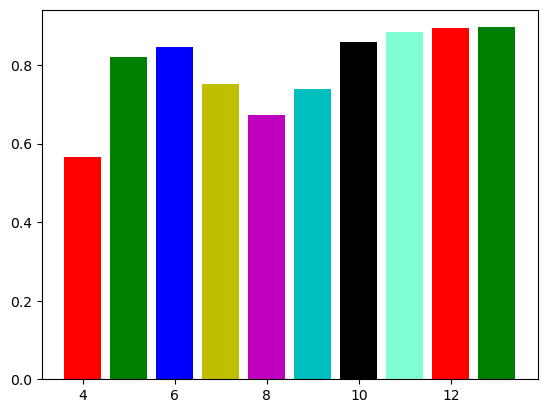

In [27]:
plt.bar(age_pct_pivot.columns, age_pct_pivot.loc[1], color = ['r','g','b','y','m','c', 'k', 'aquamarine'])

In [67]:
al30_df["AL30EST"].value_counts()

AL30EST
1    119
2     83
3     61
4     56
5     18
6      3
Name: count, dtype: int64